In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("estimate_power_consumption.xlsx")
data.head()

,unit_no,maxa,maxr,active,reactive,consumption
0,1,1322,1043,26815.0,568.0,264.452105
1,2,1316,1032,24773.0,253.0,39.563698
2,4,1345,1005,26820.0,112.0,191.193007
3,6,1336,1013,25470.0,150.0,185.514004
4,1,1320,1038,26875.0,636.0,216.559192


In [3]:
data.isnull().sum()

unit_no        0
maxa           0
maxr           0
active         0
reactive       0
consumption    0
dtype: int64

In [4]:
X = data[["unit_no","maxa","maxr","active","reactive"]]
y = data[["consumption"]]
y

,consumption
0,264.452105
1,39.563698
2,191.193007
3,185.514004
4,216.559192
...,...
994,2260.499827
995,2399.545032
996,165.448196
997,174.534605


In [5]:
X

,unit_no,maxa,maxr,active,reactive
0,1,1322,1043,26815.000000,568.000000
1,2,1316,1032,24773.000000,253.000000
2,4,1345,1005,26820.000000,112.000000
3,6,1336,1013,25470.000000,150.000000
4,1,1320,1038,26875.000000,636.000000
...,...,...,...,...,...
994,8,1340,1007,27237.512695,125.000000
995,9,1347,1007,27490.889893,145.016361
996,1,1314,1035,26708.000000,262.000000
997,2,1309,1022,26580.000000,232.000000


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [8]:
# Define Ridge Regression model with alpha=0.5 (regularization strength)
lasso_model = Lasso(alpha=0.5)

In [9]:
# Fit the model to the training data 
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.5)

In [10]:
# Make predictions on the testing data 
y_pred = lasso_model.predict(X_test_scaled)

In [11]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 337888.86938666034
R-squared: 0.43937756009511275


# Tuning hyperparameters

In [12]:
# Define the Ridge model
lasso_model = Lasso()

# Define the hyperparameters to tune
param_grid = {'selection': ['cyclic','random'],
              'alpha': [0.01,0.1, 1, 10,100]}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(lasso_model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 1, 'selection': 'cyclic'}
Best score: 0.6482285093072239


# Testing Tuned hyperparameters

In [14]:
# Define Ridge Regression model with hyperparameters
lasso_model = Lasso(alpha=1,selection='cyclic')

In [15]:
# Fit the model to the training data 
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=1)

In [16]:
# Make predictions on the testing data 
y_pred = lasso_model.predict(X_test_scaled)

# Evaluation

In [17]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 337297.4432595029
R-squared: 0.43833340094432127


# Trying dimention reduction to this model

In [18]:
# Apply PCA to reduce the number of features to 3
pca = PCA(n_components=X.shape[1])
X_train_pca = pca.fit_transform(X_train)

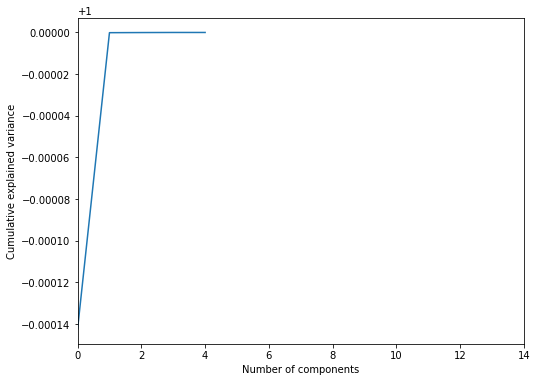

In [19]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

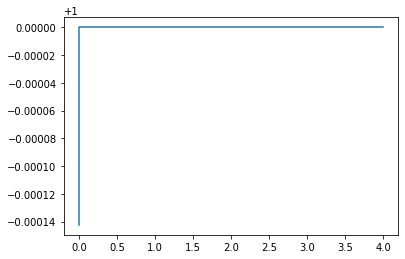

In [20]:
cumulative=np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))],cumulative)
plt.show()

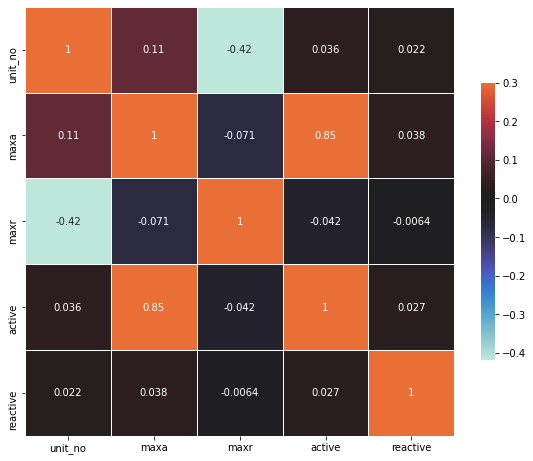

In [21]:
plt.figure(figsize=(8,8))
sns.heatmap(X_train.corr(),vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.tight_layout()
plt.show()

In [22]:
pca=PCA().fit(X_train)
print(pca.explained_variance_ratio_)
print()
print(X_train.columns.values.tolist())

[9.99857632e-01 1.42263489e-04 6.24507320e-08 4.01215868e-08
 1.80654581e-09]

['unit_no', 'maxa', 'maxr', 'active', 'reactive']


In [23]:
pipeline = Pipeline([
    ('pca', PCA(n_components=X.shape[1])),
    ('lasso', Lasso(alpha=0.5))
])

In [24]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=5)), ('lasso', Lasso(alpha=0.5))])

In [25]:
y_pred = pipeline.predict(X_test)

In [26]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 334983.6810837271
R-squared: 0.41728872690654906
